# Unlabeled

In [ ]:
import cv2
import pandas as pd
import glob
import os
import csv
import numpy as np

files = '/content/Unlabeled/*.jpg'
unlabeled_ds = []
labels = []

for file in glob.glob(files):
  imageName = file.split('/')[-1].split(".")[0] + ".jpg"
  image = cv2.imread('/content/Unlabeled/' + imageName)
  src_image = image.copy()
  segment_size_h = src_image.shape[0] // 3
  segment_size_w = src_image.shape[1] // 3
  for i in range(3):
    for j in range(3):
      image_segment = src_image[i * segment_size_h: (i+1) * segment_size_h][j * segment_size_w: (j+1) * segment_size_w]
      image_segment = cv2.resize(src_image, (512, 512))
      unlabeled_ds.append(image_segment)
      image_segment_label = [0] * 1000
      image_segment_label[3*i+j] = 1
      labels.append(image_segment_label)

unlabeled_ds = np.asarray(unlabeled_ds)
unlabeled_ds = unlabeled_ds.astype('float32')
unlabeled_ds /= 255
labels = np.asarray(labels)

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers


def build_model(num_classes):
    inputs = layers.Input(shape=(512, 512, 3))
    #x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


Epoch 1/80
37/37 - 16s - loss: 4.0921 - accuracy: 0.0939
Epoch 2/80
37/37 - 11s - loss: 2.6979 - accuracy: 0.0973
Epoch 3/80
37/37 - 11s - loss: 2.6331 - accuracy: 0.1025
Epoch 4/80
37/37 - 11s - loss: 2.5782 - accuracy: 0.1128
Epoch 5/80
37/37 - 11s - loss: 2.5886 - accuracy: 0.1077
Epoch 6/80
37/37 - 11s - loss: 2.4853 - accuracy: 0.1068
Epoch 7/80
37/37 - 11s - loss: 2.4464 - accuracy: 0.1042
Epoch 8/80
37/37 - 11s - loss: 2.4447 - accuracy: 0.1034
Epoch 9/80
37/37 - 11s - loss: 2.4133 - accuracy: 0.1111
Epoch 10/80
37/37 - 11s - loss: 2.3711 - accuracy: 0.1171
Epoch 11/80
37/37 - 11s - loss: 2.3261 - accuracy: 0.1042
Epoch 12/80
37/37 - 11s - loss: 2.3747 - accuracy: 0.1223
Epoch 13/80
37/37 - 11s - loss: 2.3530 - accuracy: 0.1197
Epoch 14/80
37/37 - 11s - loss: 2.3052 - accuracy: 0.1154
Epoch 15/80
37/37 - 11s - loss: 2.2713 - accuracy: 0.1197
Epoch 16/80
37/37 - 11s - loss: 2.2662 - accuracy: 0.1094
Epoch 17/80
37/37 - 11s - loss: 2.2655 - accuracy: 0.1059
Epoch 18/80
37/37 - 11s

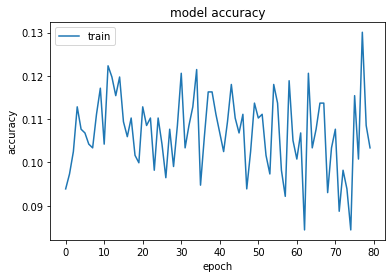

In [ ]:
#model = build_model(num_classes=1)
model = build_model(num_classes=1000)
epochs = 80  # @param {type: "slider", min:8, max:80}
hist = model.fit(x=unlabeled_ds, y=labels, epochs=epochs, verbose=2)
plot_hist(hist)

Epoch 1/50
37/37 - 17s - loss: 2.2193 - accuracy: 0.1146
Epoch 2/50
37/37 - 12s - loss: 2.2160 - accuracy: 0.1051
Epoch 3/50
37/37 - 12s - loss: 2.2042 - accuracy: 0.1146
Epoch 4/50
37/37 - 12s - loss: 2.2046 - accuracy: 0.1128
Epoch 5/50
37/37 - 12s - loss: 2.2022 - accuracy: 0.1128
Epoch 6/50
37/37 - 12s - loss: 2.2014 - accuracy: 0.1111
Epoch 7/50
37/37 - 11s - loss: 2.1991 - accuracy: 0.1171
Epoch 8/50
37/37 - 12s - loss: 2.2001 - accuracy: 0.1059
Epoch 9/50
37/37 - 12s - loss: 2.2006 - accuracy: 0.1025
Epoch 10/50
37/37 - 12s - loss: 2.2013 - accuracy: 0.0913
Epoch 11/50
37/37 - 12s - loss: 2.2008 - accuracy: 0.0930
Epoch 12/50
37/37 - 12s - loss: 2.2001 - accuracy: 0.1146
Epoch 13/50
37/37 - 12s - loss: 2.1972 - accuracy: 0.1197
Epoch 14/50
37/37 - 12s - loss: 2.1996 - accuracy: 0.1068
Epoch 15/50
37/37 - 12s - loss: 2.2019 - accuracy: 0.0982
Epoch 16/50
37/37 - 12s - loss: 2.1959 - accuracy: 0.1292
Epoch 17/50
37/37 - 12s - loss: 2.2020 - accuracy: 0.0956
Epoch 18/50
37/37 - 12s

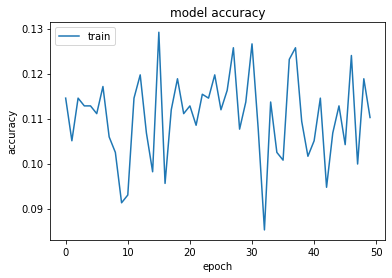

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 50  # @param {type: "slider", min:8, max:50}
hist = model.fit(x=unlabeled_ds, y=labels, epochs=epochs, verbose=2)
plot_hist(hist)


In [ ]:
model.save('/content/drive/My Drive/Models/ImgProject/unlabeled_model_2_full.h5')

In [ ]:
model.layers.pop()

In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 512, 512, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [ ]:
model.save('/content/drive/My Drive/Models/ImgProject/unlabeled_model_2_poped.h5')